In [1021]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")





## Regresion logística Vs Clasificador Bayesiano ingenuo

Compara los métodos de regresión logística y el clasificador bayesiano ingenuo en las siguientes tareas:



En primer lugar se leen los datos 

In [1016]:
# Lectura de datos Spam

# Los datos de spam vienen con tipo de datos que no permiten hacer los
# calculos pertinentes para esto se hace arreglos 
#lectura de datos
spam = pd.read_csv("spam.csv")
data_spam = spam.to_numpy()

# Se hace para poner todos los datos como arrays, vienen compactos los datos
x = []
for i in range(len(data_spam)): 
    x.append(np.array([float(i) for i in data_spam[i][0].split()]))
x = np.array(x)
x = np.random.permutation(x)

# Se definen los datos y los objetivos
x_data_s = x[:,:-1]
x_target_s = x[:,-1:]

print("Spam")
print("Tamaño de datos = {}, objetivos = {}".format(np.shape(x_data_s),np.shape(x_target_s)))

Spam
Tamaño de datos = (5171, 2000), objetivos = (5171, 1)


In [1017]:
# Lectura datos cancer

# Definimos lista con los nombres de las características 
Names = ["ID ","Grosor del tumor","Uniformidad tamaño",
            "forma celula","Adhesion marginal","Tamaño celula epitelial",
            "Nucleos desnudos","Cromatina blanda","Núcleolos normales",
           "Mitosis de celulas","Clase"]
cancer = pd.read_csv("breast-cancer-wisconsin.data",names = Names)
# Eliminamos la columna de ID, no brinda información dado que no se repite
cancer = cancer.drop([cancer.columns[0]],axis = 1)
data_cancer = cancer.to_numpy()

# Para trabajar con uniformidad eliminamos los datos con "?" y asi poder comparar los 
# modelos, el objetivo es poder ver que algoritmo tiene mejor rendimiento 

index = np.where(data_cancer == "?")
data_cancer = np.delete(data_cancer,index,axis=0)
data_cancer[:,5] = data_cancer[:,5].astype(np.float)
data_cancer = data_cancer.astype(np.float)

data_cancer = np.random.permutation(data_cancer)



x_data_c = data_cancer[:,:-1]
x_target_c = data_cancer[:,-1:]

print("Cancer")
print("Tamaño de datos = {}, objetivos = {}".format(np.shape(x_data_c),np.shape(x_target_c)))

Cancer
Tamaño de datos = (682, 9), objetivos = (682, 1)


Hacemos los modelos para cada uno de los problemas

* Clasificador de spam

Rendimiento del modelo Naive Bayes = 0.959


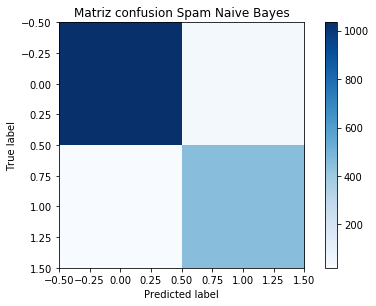

Rendimiento del modelo Regresión Logistica = 0.967


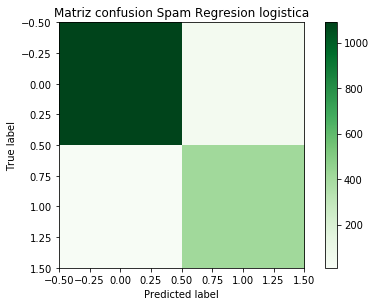

In [1036]:
# Clasificacion de spam

X_trainNBs, X_testNBs, Y_trainNBs,Y_testNBs = train_test_split(x_data_s,x_target_s,test_size = 0.3)
# Modelo Bayesiano ingenuo
spam_model_NB = MultinomialNB(alpha = 1e-10, class_prior = None, fit_prior=False)
spam_model_NB.fit(X_trainNBs,np.ravel(Y_trainNBs))
print("Rendimiento del modelo Naive Bayes = {:.3f}".format(spam_model_NB.score(X_testNBs,Y_testNBs)))
pred_prob_NB = spam_model_NB.predict(X_testNBs)

cms = confusion_matrix(Y_testNBs,pred_prob_NB)
plt.imshow(cms,interpolation = "nearest",cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Matriz confusion Spam Naive Bayes")
plt.colorbar()
plt.show()



# Modelo de regresión logística
X_trainLRs, X_testLRs, Y_trainLRs,Y_testLRs = train_test_split(x_data_s,x_target_s,test_size = 0.3)
spam_model_LR = LogisticRegression(random_state=0,solver= "newton-cg")
spam_model_LR.fit(X_trainLRs,np.ravel(Y_trainLRs))
print("Rendimiento del modelo Regresión Logistica = {:.3f}".format(spam_model_LR.score(X_testLRs,Y_testLRs)))
pred_prob_LR = spam_model_LR.predict(X_testLRs)

cms = confusion_matrix(Y_testLRs,pred_prob_LR)
plt.imshow(cms,interpolation = "nearest",cmap = plt.cm.Greens)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Matriz confusion Spam Regresion logistica")
plt.colorbar()
plt.show()




* Clasificador de tumores de Seno 

Rendimiento del modelo Naive Bayes = 0.956


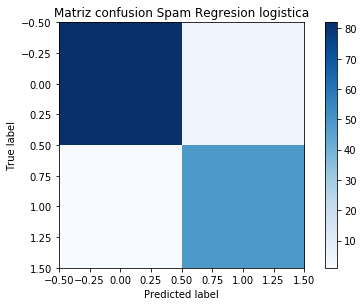

Rendimiento del modelo Regresión logística = 0.964


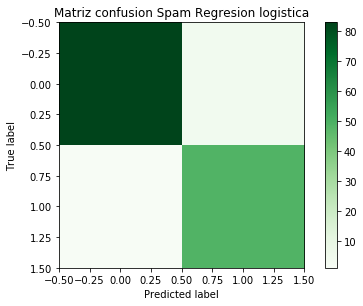

In [1040]:
#Clasificacion de tumores de Seno

# Modelo Bayesiano ingenuo
X_trainNBc, X_testNBc, Y_trainNBc,Y_testNBc = train_test_split(x_data_c,x_target_c,test_size = 0.2)
cancer_model_G = GaussianNB()
cancer_model_G.fit(X_trainNBc,np.ravel(Y_trainNBc))
print("Rendimiento del modelo Naive Bayes = {:.3f}".format(cancer_model_G.score(X_testNBc,Y_testNBc)))
pred_prob_G = cancer_model_G.predict(X_testNBc)

cms = confusion_matrix(Y_testNBc,pred_prob_G)
plt.imshow(cms,interpolation = "nearest",cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Matriz confusion Spam Regresion logistica")
plt.colorbar()
plt.show()

#Modelo de regresion Logistica
X_trainLRc, X_testLRc, Y_trainLRc,Y_testLRc = train_test_split(x_data_c,x_target_c,test_size = 0.2)
cancer_model_G = LogisticRegression(random_state=0,solver= "liblinear")
cancer_model_G.fit(X_trainLRc,np.ravel(Y_trainLRc))
print("Rendimiento del modelo Regresión logística = {:.3f}".format(cancer_model_G.score(X_testLRc,Y_testLRc)))
pred_prob_G = cancer_model_G.predict(X_testLRc)

cms = confusion_matrix(Y_testLRc,pred_prob_G)
plt.imshow(cms,interpolation = "nearest",cmap = plt.cm.Greens)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Matriz confusion Spam Regresion logistica")
plt.colorbar()
plt.show()

Se hace la implementación de el modelo de scikit learn en el caso de regresión logistica para tener una refencia y comparar el modelo que se va a construir y ver si dista mucho del modelo ya programado correctamente

In [1004]:
class LogisticR(object):
    
    def __init__(self, η = 0.01 , MaxIter = 100, intercept = True ,Error = False):
        self.η = η
        self.MaxIter = MaxIter
        self.intercept = intercept
        self.Error = Error
        #self.l = l
    # Consideracion del punto de corte, añadir los unos a la matriz de diseño
    def Intercept(self,x):
        unos = np.ones((np.shape(x)[0],1))
        Phi = np.concatenate((unos,x),axis = 1)
        return Phi
    
    # Definición de la f uncion sigmoide
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def Loss(self,h,y):
        #return np.mean(-y*np.log(h)-(1-y)*np.log(1-h))
        return np.sum((y-h)**2)/len(y)
        
    # Definicion del ajuste
    def fit(self,x,y):
        if self.intercept == True:
            x = self.Intercept(x)
            
        # Inicializacion aleatoria de los pesos 
        #self.w = np.random.uniform(0,1,(1,np.shape(x)[1])).T
        self.w = np.zeros((1,np.shape(x)[1])).T
        if self.Error == True:
            self.l = np.zeros(self.MaxIter)
        
        # Ciclo de optimización de los parámetros 
        for i in range(self.MaxIter):
            z = np.dot(x, self.w)
            h = sigmoid(z)
            g = np.dot(x.T, (h - y)) / y.shape[0]
            self.w = self.w -η*g
            
            if self.Error == True :
                z = np.dot(x, self.w)
                h = sigmoid(z)
                self.l[i] = self.Loss(h,y)
            
    # Definicion del calculo de la probabilidad
    def predict_probs(self, x):
            if self.intercept == True:
                return self.sigmoid(np.dot(x, self.w[1:]))
    
    #discriminacion
    def predict(self, x, umbral = 0.5):
            return self.predict_probs(x) >= umbral
        
    def score(self,x,y):
        return sum(self.predict(x) == y)/np.shape(y)[0]
    
    def plot_error(self):
        plt.plot(self.l,"b.",label = "Error = "+str(round(self.l[-1],4)))
        plt.grid(True)
        plt.xlabel("Pasos")
        plt.ylabel("Error")
        plt.title("Disminución del error")
        plt.legend(fancybox = True,shadow = True,borderpad = 1)
        






### Regresión logística para la clasificación de spam 

Para este modelo se tienen $N = 5171$ datos recopilados y $M = 2000$ características. A continuación debemos considerar dos clases, es o no spam

debemos encontrar la actualización de los parámetros del modelo a través de la siguiente expresión 

$$\vec{\omega}^{\tau+1} = \vec{\omega}^{\tau} - \eta\nabla_{\omega}E(\vec{\omega})$$


Se hace la separacion de los datos para hacer el entrenamiento del modelo

In [1018]:
# Separación de los datos
t = 0.8

x_train = x_data_s[0:int(t*len(x_data_s))]
x_val = x_data_s[int(t*len(x_data_s)):]

y_train = x_target_s[0:int(t*len(x_data_s))]
y_val = x_target_s[int(t*len(x_data_s)):]

Se construye el modelo para hacer el entrenamiento 

In [1019]:
model_spam = LogisticR(η = 0.1, MaxIter = 100, Error = True)
model_spam.fit(x_train,y_train)
model_spam.score(x_val,y_val)

array([0.80869565])

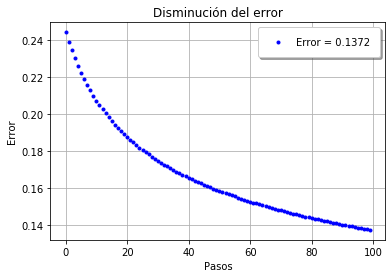

In [1015]:
model_spam.plot_error()

### Regresión logística para la clasificación de cancer de Seno

In [1008]:
# Separación de los datos
x_data_c = data_cancer[:,:-1]
x_target_c = data_cancer[:,-1:]

t = 0.8

x_train = x_data_c[0:int(t*len(x_data_c))]
x_val = x_data_c[int(t*len(x_data_c)):]

y_train = x_target_c[0:int(t*len(x_data_c))]
y_val = x_target_c[int(t*len(x_data_c)):]

# convertir a unos y ceros los vectores objetivo 
# 2 ----> no tiene cancer corresponde a 0
# 4 ----> tiene cancer corresponde a 1
y_train = np.where(y_train == 2,0,1)
y_val = np.where(y_val == 2,0,1)




In [1009]:
model_cancer = LogisticR(η = 0.1,MaxIter= 100,Error = True)
model_cancer.fit(x_train,y_train)
model_cancer.score(x_val,y_val)

array([0.81021898])

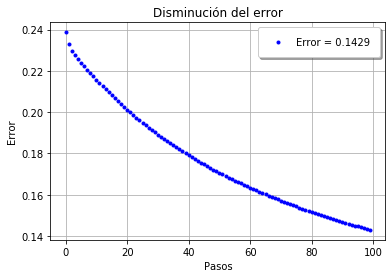

In [1010]:
model_cancer.plot_error()